In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import yaml
import os
import cv2

In [2]:
task = ["openable", "cuttable", "pourable", "containable", "supportable", "holdable"]

In [3]:
def plot_heatmap(image, heatmaps):
    assert len(heatmaps) == len(task)

    plt.figure(figsize=(30, 4))
    for idx, heatmap in enumerate(heatmaps):
        heatmap = np.uint8(np.array(heatmap) * 255)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        img = cv2.addWeighted(heatmap, 0.6, img, 0.4, 0)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, len(heatmaps), idx+1)
        plt.imshow(img)
        plt.title(f"class: {task[idx]}")
    plt.show()

In [4]:
from model import CerberusCAMModel

model = CerberusCAMModel(len(task))

resume_time = "20220807_231928"
resume_level = "checkpoint_latest"
resume_path = f"output/{resume_time}/model/{resume_level}.pth"

ckpt = torch.load(resume_path)

model.load_state_dict(
    {
        k.replace("module.", ""): v
        for k, v in ckpt["state_dict"].items()
    }
)
model.eval()

print(f"Best score: {ckpt['best_score']}")

Best score: 81.58597086159274


In [5]:
image_label_path = os.path.join("../dataset/cad120/object/train_affordance_image_label.yaml")
with open(image_label_path, "r") as fb:
    image_label_dict = yaml.safe_load(fb)

In [10]:
file_name = "11490_1"
input_path = f"../dataset/cad120/object/affordance/images/{file_name}.png"
target_path = f"../dataset/cad120/object/affordance/labels/{file_name}.pkl"

file_name = os.path.basename(input_path).split(".")[0]
image = Image.open(input_path).resize((320, 320), Image.Resampling.BICUBIC)
image_label = image_label_dict[file_name]
with open(target_path, "rb") as fb:
    dense_label = pickle.load(fb)
    dense_label = [Image.fromarray(dense_label[:, :, i]).resize((320, 320), Image.Resampling.NEAREST) for i in range(dense_label.shape[2])]

mean = [132.47758921, 106.32022472, 111.57047992]
std = [67.45043020, 70.23484331, 72.19806953]

mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

input = torch.from_numpy(np.array(image)).permute(2, 0, 1).contiguous().float()
input = (input - mean) / std
input = input.unsqueeze(0)

In [7]:
with torch.no_grad():
    output = model(input, gen_cam=True)
    output_cls = model(input, gen_cam=False)

In [12]:
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad, \
    GradCAMElementWise
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [13]:
grayscale_cam_list = []
for i in range(len(task)):
    cam = GradCAMPlusPlus(model=model, target_layers=[model.head_dict[str(i)]], use_cuda=False)
    targets = [ClassifierOutputTarget(0) for _ in range(len(task))]
    grayscale_cam = cam(input_tensor=input, targets=targets).squeeze(0)
    grayscale_cam_list.append(grayscale_cam)

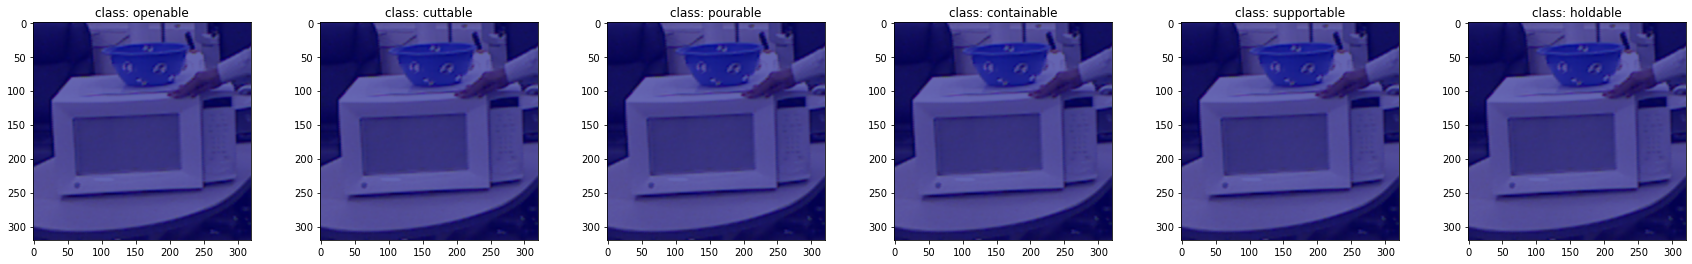

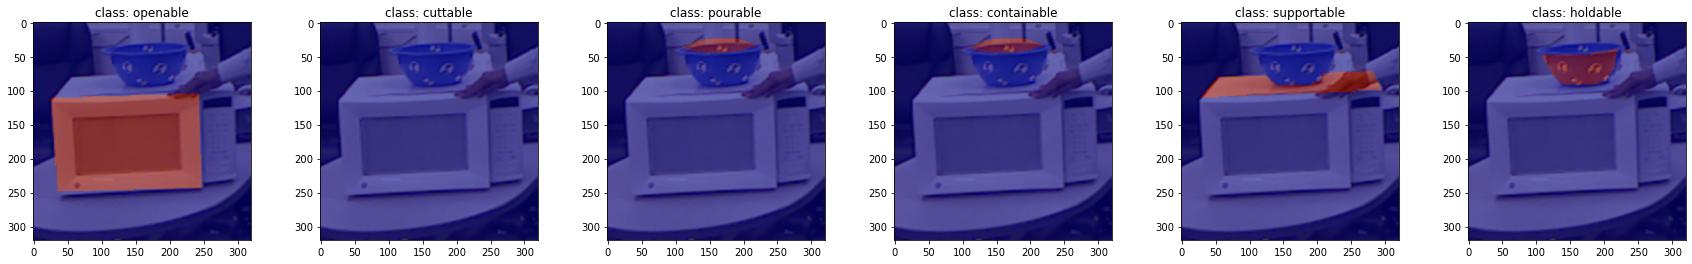

In [14]:
plot_heatmap(image, grayscale_cam_list)
plot_heatmap(image, dense_label)

[0, 0, 1, 1, 1, 1]


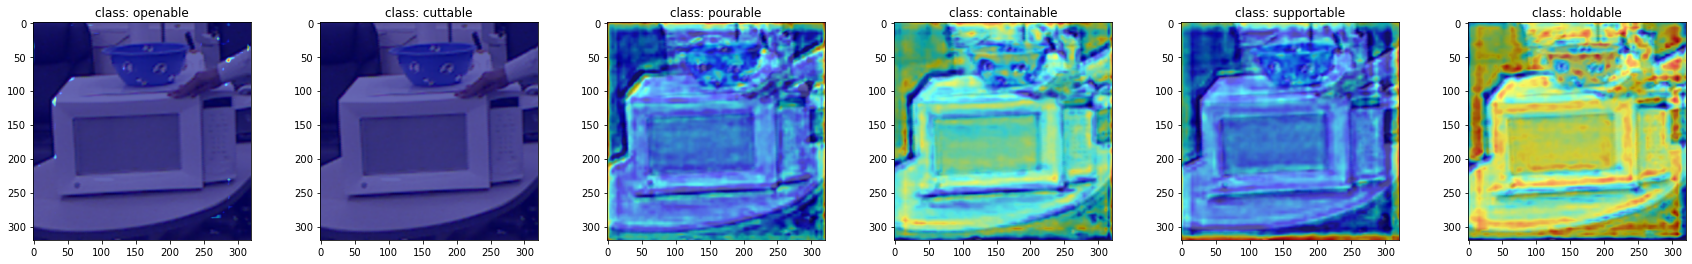

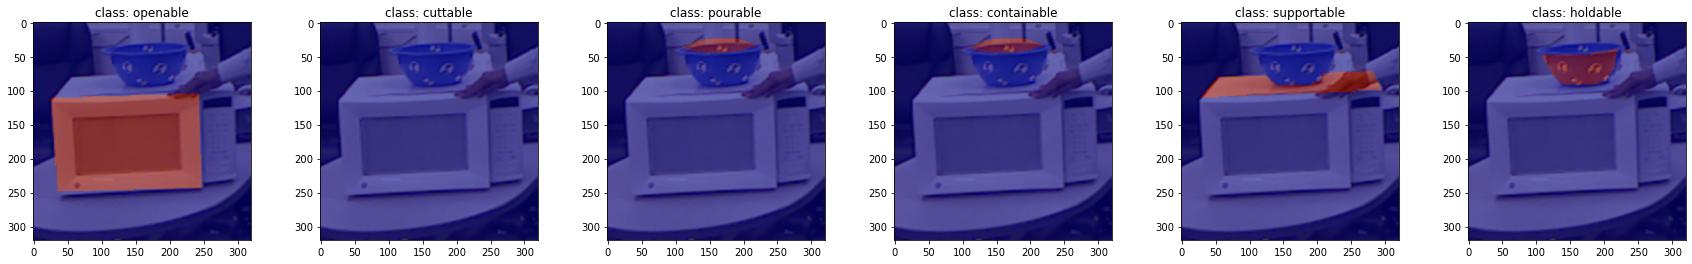

In [11]:
cam_label = []
for i in range(len(task)):
    if image_label[i] == 2:
        out = np.zeros((320, 320), dtype=np.float32)
    else:
        out = torch.nn.functional.interpolate(output[i], (320, 320), mode='bilinear', align_corners=True)
        # out = torch.sigmoid(out)
        out = torch.nn.functional.relu(out)
        out /= torch.nn.functional.adaptive_max_pool2d(out, (1, 1)) + 1e-8
        out = out.squeeze(0).squeeze(0).cpu().numpy()
    cam_label.append(out)

cls_label = []
for i in range(len(task)):
    out_cls = (output_cls[i].sigmoid() > 0.5).int()
    cls_label.append(out_cls[0].item())

print(cls_label)
plot_heatmap(image, cam_label)
plot_heatmap(image, dense_label)